<a href="https://colab.research.google.com/github/c0natus/dangerzone-converter/blob/master/Creditcard_Fraud_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---
# 구글 드라이브에 저장되어 있는 데이터를 불러오기 위해 구글 드라이브를 마운트한다.
---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




---
# 구글 드라이브에서 데이터를 불러오고 pandas의 describe method를 통해 데이터의 평균과 표준편차를 알아본다.


---



In [211]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import GridSearchCV, ShuffleSplit, learning_curve, cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier



df = pd.read_csv('/content/drive/MyDrive/Credit_fraud/data/creditcard.csv')
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000




---
# 정규분포 표준화를 진행한다.


---



In [88]:
std_scaler= StandardScaler()

df['Time'] = std_scaler.fit_transform(df['Time'].values.reshape(-1,1))
df['Amount'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1,1))

df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,-1.050379e-14,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,3.202236e-16,0.001727
std,1.000002e+00,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,1.000002e+00,0.041527
min,-1.996583e+00,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,-3.532294e-01,0.000000
25%,-8.552120e-01,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,-3.308401e-01,0.000000
50%,-2.131453e-01,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,-2.652715e-01,0.000000
75%,9.372174e-01,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,-4.471707e-02,0.000000
max,1.642058e+00,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.023622e+02,1.000000




---
# 데이터의 결측값과 class의 종류를 알아본다.


---



In [4]:
df.isnull().sum().max()

0

In [5]:
df['Class'].unique()

array([0, 1])



---
# 데이터의 분포와 피어슨 상관계수를 시각화 한다.


---



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


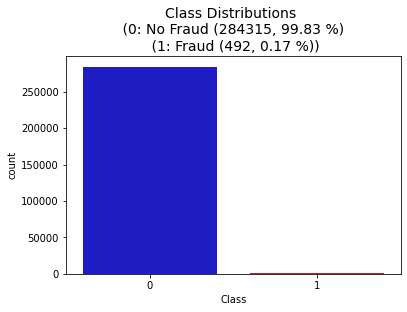

In [6]:
# data distribution 시각화
row_cnt = len(df)
zero_cnt = df['Class'].value_counts()[0]
one_cnt = df['Class'].value_counts()[1]
ratio_no_fraud = round(zero_cnt/row_cnt * 100,2)
ratio_fraud = round(one_cnt/row_cnt * 100,2)


colors = ["#0101DF", "#DF0101"]
sns.countplot('Class', data=df, palette=colors)
plt.title(f'Class Distributions \n (0: No Fraud ({zero_cnt}, {ratio_no_fraud} %) '
          f'\n (1: Fraud ({one_cnt}, {ratio_fraud} %))', fontsize=14)

plt.show()

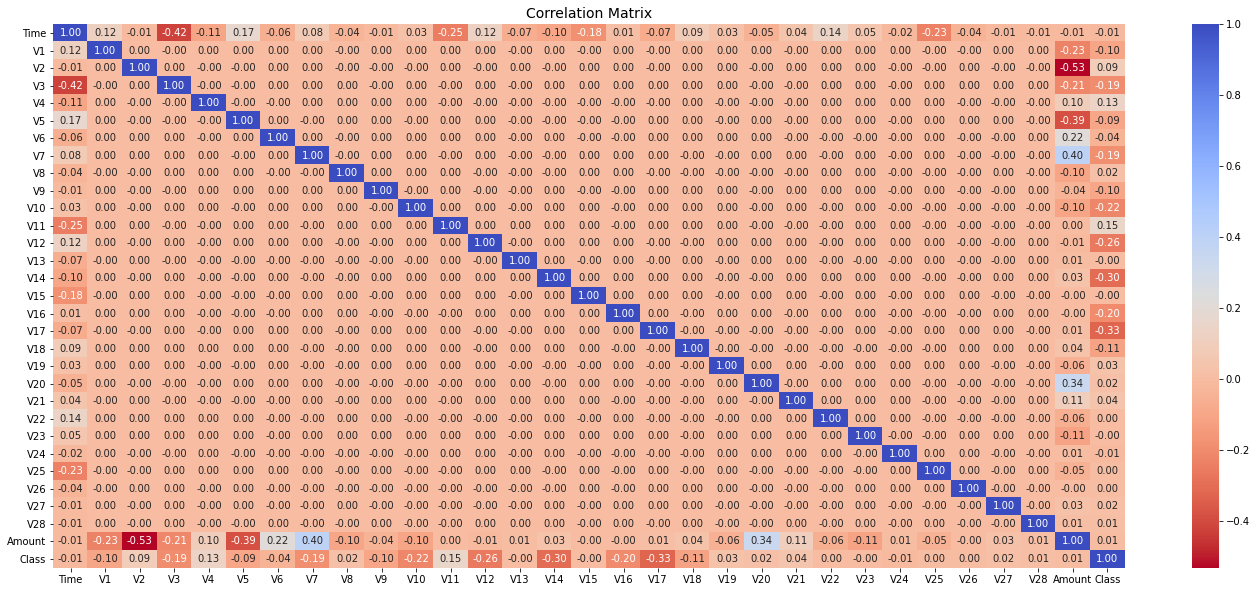

In [7]:
# Data Correlation Matrices
# pandas corr를 통해 피어슨 상관계수 사용
corr = df.corr()
plt.figure(figsize=(24,10))
ax=sns.heatmap(corr, fmt='0.2f', cmap='coolwarm_r', annot = True)
ax.set_title("Correlation Matrix", fontsize=14)

plt.show()



---

# train과 test set을 4:1로 나눈다.


---




In [89]:
x = df.drop('Class',axis=1)
y = df['Class']

# stratify 옵션은 train data와 test data의 샘플의 클래스 비율을 일정하게 하게한다.
# train: test = 4 : 1
x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y, random_state = 42, test_size = 0.2)



---
# train data set으로 undersampling을 진행한다.
# fraud : no fraud = 1 : 9이다.
# 데이터 분포와 피어슨 상관계수를 시각화 한다.


---




In [241]:
# UnderSampling : Random UnderSampling
# dataframe.sample(frac=1) : data를 뽑기전 random하게 섞기
x_train.sample(frac=1)

tmp_df = pd.concat([x_train, y_train], axis=1)

ratio = 394 * 9

fraud_df = tmp_df.loc[df['Class'] == 1]
no_fraud_df = tmp_df.loc[df['Class'] == 0][:ratio]

# pd.concat: data frame 합치기
undersampling_df = pd.concat([fraud_df, no_fraud_df])

x_train_under = undersampling_df.drop('Class', axis=1)
y_train_under = undersampling_df['Class']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


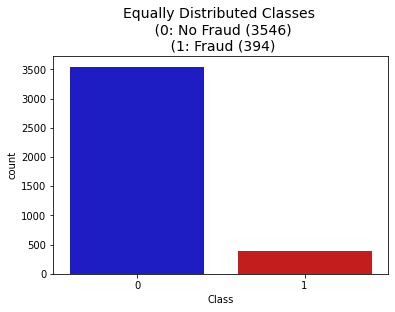

In [242]:
# undersampling data distribution 시각화


u_zero_cnt = undersampling_df['Class'].value_counts()[0]
u_one_cnt = undersampling_df['Class'].value_counts()[1]
colors = ["#0101DF", "#DF0101"]
sns.countplot('Class', data=undersampling_df, palette=colors)
plt.title(f'Equally Distributed Classes \n (0: No Fraud ({u_zero_cnt})'
            f'\n (1: Fraud ({u_one_cnt})', fontsize=14)
plt.show()

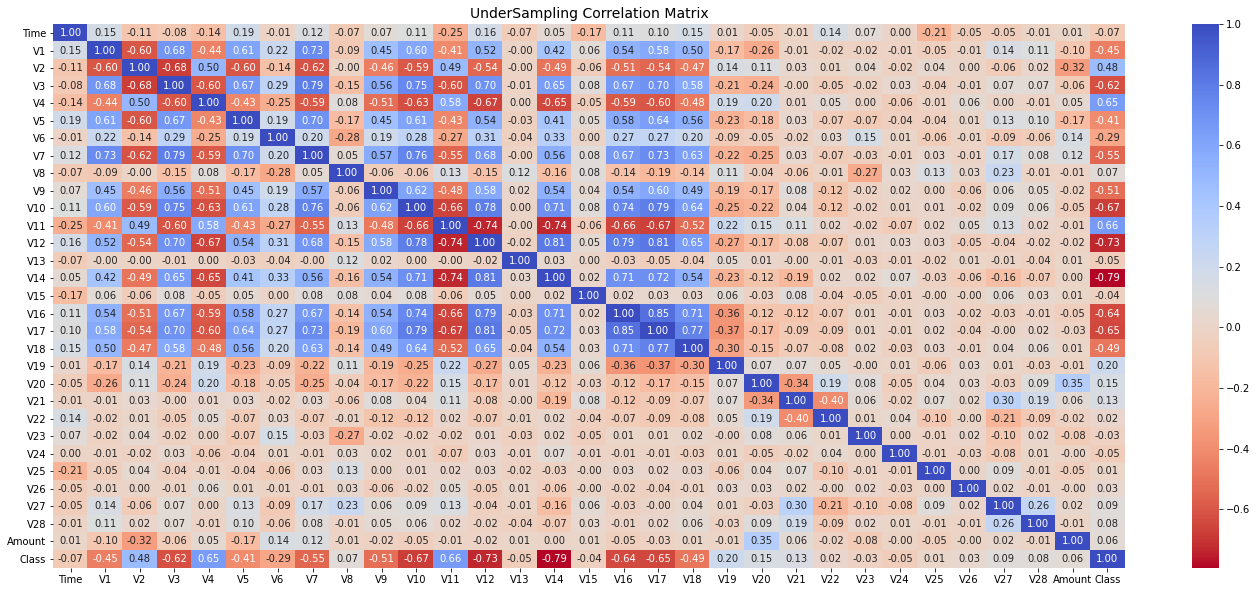

In [243]:
# undersampling data correlation
# pandas corr를 통해 피어슨 상관계수 사용
plt.figure(figsize=(24,10))

sub_sample_corr = undersampling_df.corr()
ax=sns.heatmap(sub_sample_corr, fmt='0.2f', cmap='coolwarm_r', annot = True)
ax.set_title('UnderSampling Correlation Matrix', fontsize=14)
plt.show()



---

# train data set으로 oversampling을 진행한다.
# fraud : no fraud = 1 : 9이다.
# 데이터 분포와 피어슨 상관계수를 시각화 한다.


---



In [173]:
# Oversampling SMOTE

smote = SMOTE(random_state=42, sampling_strategy=0.1)
x_train_over, y_train_over = smote.fit_sample(x_train,y_train)

# adasyn = ADASYN(random_state = 42, sampling_strategy=0.1)
# x_train_over, y_train_over = adasyn.fit_sample(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


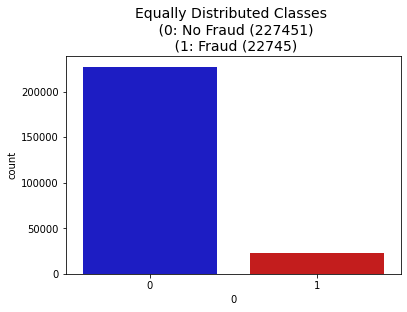

In [134]:
new_df = pd.concat([pd.DataFrame(x_train_over), pd.DataFrame(y_train_over)], axis=1)
label = new_df.iloc[:,-1]
u_zero_cnt = label.value_counts()[0]
u_one_cnt = label.value_counts()[1]
colors = ["#0101DF", "#DF0101"]
sns.countplot(label, palette=colors)
plt.title(f'Equally Distributed Classes \n (0: No Fraud ({u_zero_cnt})'
            f'\n (1: Fraud ({u_one_cnt})', fontsize=14)
plt.show()

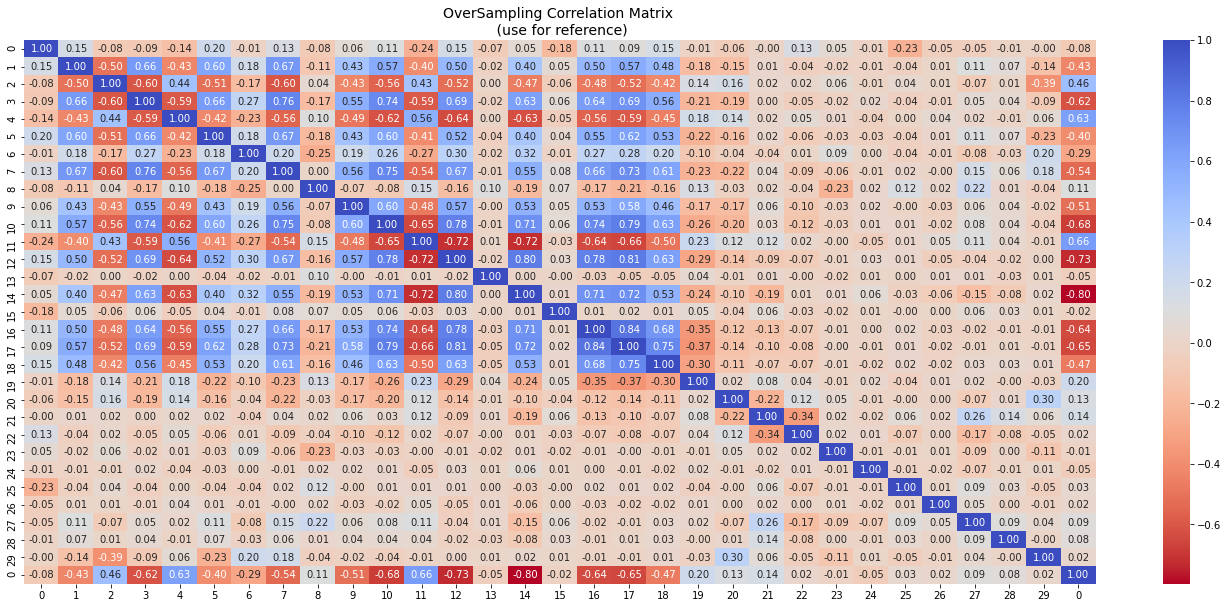

In [135]:
# pandas corr를 통해 피어슨 상관계수 사용
plt.figure(figsize=(24,10))

over_sample_corr = new_df.corr()
ax=sns.heatmap(over_sample_corr, fmt='0.2f', cmap='coolwarm_r', annot = True)
ax.set_title('OverSampling Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()



---

# metric 함수와 plot learning curve 함수를 정의한다.
---

In [15]:
# Recall : TP/TP+FN
# Precision = TP/TP+FP
# Accuracy = (TP+TN)/(TP+FP+FN+TN)
# F1 score = 2 * (Precison * Recall) / (Precision + Recall)
def print_metric(y_test, y_pred):
    print(f"Recall Score: {recall_score(y_test, y_pred)}")
    print(f"Precision Score: {precision_score(y_test, y_pred)}")
    print(f"F1 Score: {f1_score(y_test, y_pred)}")
    print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")
    print(f"AUC: {roc_auc_score(y_test, y_pred, average='macro')}")

In [354]:
# ylim: y축 범위 제한
# cv: default = none >> 5
# n_jobs: 연산을 위한 CPU 개수 지정
# train_sizes: learning curve 생성시 사용할 데이터 사이즈 지정 (training set의 상대적인 또는 절대적인 숫자)
def plot_learning_curve(estimator, x, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 20), s='neg_log_loss'):
    # train_sizes의 80%(cv=5)를 0.1, 0.325, 0.55, 0.775, 1의 비율로 학습시긴다.
    train_sizes, train_scores, test_scores = learning_curve(estimator, x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=s)
    if s.find('neg') != -1:
        train_scores, test_scores = -train_scores, -test_scores
    train_scores_mean = np.nanmean(train_scores, axis = 1)
    test_scores_mean = np.nanmean(test_scores, axis = 1)
    plt.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff", label="Cross-validation score")
    plt.xlabel('Training size')
    plt.ylabel('Loss')
    # 그림에 선 표시
    plt.grid(True)
    # 범례 표시: best - 자동으로 최적의 위치에
    plt.legend(loc="best")
    plt.show()

cv = ShuffleSplit(test_size=0.2, random_state=10)



---

# K Nearest Neighborhood

---



In [ ]:
knc_under = KNeighborsClassifier(n_neighbors=2)
knc_under.fit(x_train_under, y_train_under)
y_pred = knc_under.predict(x_test)

print_metric(y_test, y_pred)

Recall Score: 0.8673469387755102
Precision Score: 0.5862068965517241
F1 Score: 0.699588477366255
Accuracy Score: 0.998718443874864
AUC: 0.9331458948238833


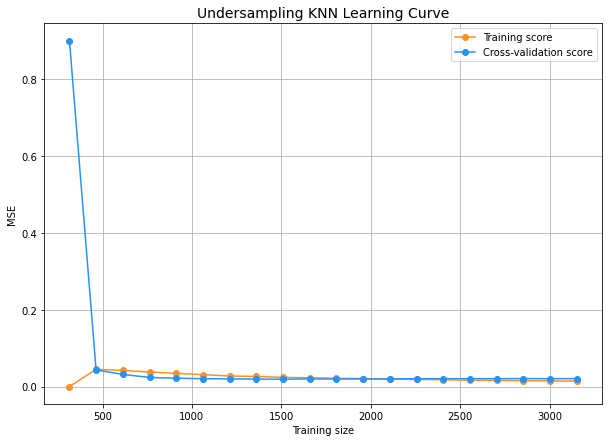

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Undersampling KNN Learning Curve", fontsize=14)
plot_learning_curve(knc_under, x_train_under, y_train_under)

In [ ]:
knc_over = KNeighborsClassifier(n_neighbors=2)
knc_over.fit(x_train_over, y_train_over)
y_pred = knc_over.predict(x_test)

print_metric(y_test, y_pred)

Recall Score: 0.8469387755102041
Precision Score: 0.7345132743362832
F1 Score: 0.7867298578199051
Accuracy Score: 0.9992099996488887
AUC: 0.9232056004731664


In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Oversampling KNN Learning Curve", fontsize=14)
plot_learning_curve(knc_over, x_train_over, y_train_over)



---

# Logistic Regression

---



In [362]:
lr_under = LogisticRegression(C=3, max_iter=1000)
lr_under.fit(x_train_under, y_train_under)
y_pred = lr_under.predict(x_test)

print_metric(y_test, y_pred)

Recall Score: 0.8877551020408163
Precision Score: 0.3129496402877698
F1 Score: 0.4627659574468085
Accuracy Score: 0.9964537762016783
AUC: 0.9421981053254165


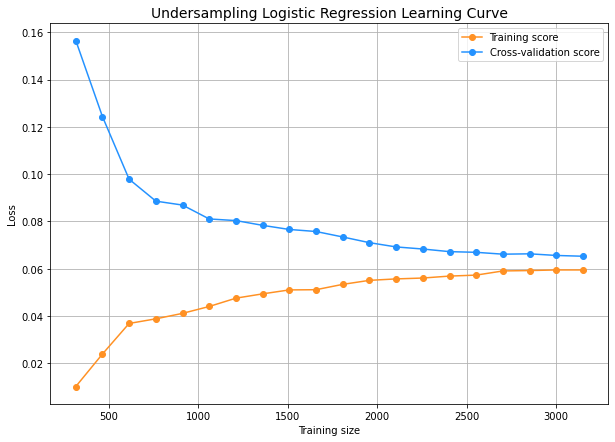

In [363]:
plt.figure(figsize=(10, 7))
plt.title("Undersampling Logistic Regression Learning Curve", fontsize=14)
plot_learning_curve(lr_under, x_train_under, y_train_under, cv=cv)

In [364]:
lr_over = LogisticRegression(C=3, max_iter=1000)
lr_over.fit(x_train_over, y_train_over)
y_pred = lr_over.predict(x_test)

print_metric(y_test, y_pred)

Recall Score: 0.8877551020408163
Precision Score: 0.36099585062240663
F1 Score: 0.5132743362831859
Accuracy Score: 0.9971033320459254
AUC: 0.9425234429731374


In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Oversampling Logistic Regression Learning Curve", fontsize=14)
plot_learning_curve(lr_over, x_train_over, y_train_over, cv = cv)



---

# Support Vector Machine

---



In [ ]:
svc_under = SVC(C=0.0000007, kernel='linear')
svc_under.fit(x_train_under, y_train_under)
y_pred = svc_under.predict(x_test)

print_metric(y_test, y_pred)

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Undersampling Support Vector Machine Learning Curve", fontsize=14)
plot_learning_curve(svc_under, x_train_under, y_train_under)

In [ ]:
svc_over = SVC(C=0.0000007, kernel='linear')
svc_over.fit(x_train_over, y_train_over)
y_pred = svc_over.predict(x_test)

print_metric(y_test, y_pred)

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Oversampling Support Vector Machine Learning Curve", fontsize=14)
plot_learning_curve(svc_over, x_train_over, y_train_over)



---

# Multi-layer perceptron

---



In [ ]:
from tensorflow import optimizers, keras
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, InputLayer
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives
from tensorflow.keras.metrics import TruePositives, Precision, Recall

def shuffle_array(x, y):
    s = np.arange(x_train.shape[0])
    np.random.shuffle(s)
    x = x[s]
    y = y[s]

    return x, y

model = Sequential([
        Dense(256, activation="relu", input_shape=(x_train_over.shape[-1],)),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(1, activation="sigmoid"),
        ])

model.summary()

metrics = [
    'acc',
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(optimizer= optimizers.Adam(learning_rate=0.001,),
              loss='binary_crossentropy',
              metrics=metrics,
              )

ep = 15
bs = 512
history = model.fit(x_train_over, y_train_over, epochs=ep, batch_size=bs, validation_data=(x_test, y_test),)
score = model.evaluate(x_test, y_test, verbose=0)

In [ ]:
print(f'Recall Score: {sum(re)/5}')
print(f'Precision Score: {sum(pre)/5}')
print(f'F1 Score: {sum(f1)/5}')
print(f'Accuracy Score: {sum(ac)/5}')

In [ ]:
print(f'Recall Score: {score[7]}')
print(f'Precision Score: {score[6]}')
print(f'F1 Score: {2 * score[7] * score[6] / (score[7] + score[6])}')
print(f'Accuracy Score: {score[1]}')
x_scope = list(range(1,ep+1))

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(x_scope, history.history['loss'], label='Training Loss')
plt.plot(x_scope, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Error')
# 그림에 선 표시
plt.grid(True)
# 범례 표시: best - 자동으로 최적의 위치에
plt.legend(loc="best")
plt.show()

In [ ]:
rec = history.history['val_recall']
pre = history.history['val_precision']
f1 = [0] * ep
for i in range(ep):
    f1[i] = 2 * rec[i] * pre[i] / (rec[i] + pre[i])

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(x_scope, rec, label='Recall')
plt.plot(x_scope, pre, label='Precision')
plt.plot(x_scope, f1, label='F1')
plt.xlabel('epochs')
plt.ylabel('Score')
# 그림에 선 표시
plt.grid(True)
# 범례 표시: best - 자동으로 최적의 위치에
plt.legend(loc="best")
plt.show()



---

# CNN

---



In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import GridSearchCV, ShuffleSplit, learning_curve, cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

re = [0] * 5
pre = [0] * 5
ac = [0] * 5
f1 = [0] * 5

for i in range(5):
    x = df.drop('Class',axis=1)
    y = df['Class']
    
    # stratify 옵션은 train data와 test data의 샘플의 클래스 비율을 일정하게 하게한다.
    # # train: test = 4 : 1
    # # train: 394개의 fraud // test: 98개의 fraud
    x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y, test_size = 0.2, random_state=2)
    
    smote = SMOTE(random_state = 2, sampling_strategy=0.7)
    x_train_over, y_train_over = smote.fit_sample(x_train,y_train)
    
    x_train_over = x_train_over.reshape(x_train_over.shape[0] , x_train_over.shape[1],1)
    x_test = x_test.to_numpy()
    x_test = x_test.reshape(x_test.shape[0] , x_test.shape[1],1)
    
    # Initialising the CNN
    classifier = tf.keras.models.Sequential()
    classifier.add(tf.keras.layers.Convolution1D(32 , 2 , activation='relu',input_shape=x_train_over[0].shape))
    classifier.add(tf.keras.layers.BatchNormalization())
    classifier.add(tf.keras.layers.Dropout(0.2))
    
    classifier.add(tf.keras.layers.Convolution1D(64 , 2 , activation='relu'))
    classifier.add(tf.keras.layers.BatchNormalization())
    classifier.add(tf.keras.layers.Dropout(0.2))
    
    classifier.add(tf.keras.layers.Convolution1D(128 , 2 , activation='relu'))
    classifier.add(tf.keras.layers.BatchNormalization())
    classifier.add(tf.keras.layers.Dropout(0.2))
    
    classifier.add(tf.keras.layers.Flatten())
    classifier.add(tf.keras.layers.Dense(units=256, activation='relu'))
    classifier.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    
    metrics = [
        'acc',
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]

    classifier.compile(optimizer=Adam(lr = 0.001), loss='binary_crossentropy', metrics=metrics)
    classifier.summary()

    ep = 43
    bs = 512
    history = classifier.fit(x_train_over, y_train_over, epochs=ep, batch_size=bs, validation_data=(x_test, y_test),)
    score = classifier.evaluate(x_test, y_test, verbose=0)

    re[i] = score[7]
    pre[i] = score[6]
    f1[i] = 2 * score[7] * score[6] / (score[7] + score[6])
    ac[i] = score[1]

print(re, pre, f1, ac, sep='\n')